**Decision Part**

In [50]:
!pip install catboost --quiet

In [51]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [52]:
import warnings
warnings.filterwarnings('ignore') # Filter out warnings to ignore them

In [53]:
# DataReading and Understanding
file = ("/content/drive/MyDrive/Colab Notebooks/TeachForIndia/Test_data.csv")

df = pd.read_csv(file)

In [54]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [55]:
#Data Cleaning and Preprocessing
test_data = df.drop('employee_id', axis=1)

In [56]:
#Testing for any Duplicate Values
test_data.duplicated().sum()

26

In [57]:
test_data.drop_duplicates(inplace=True)

In [58]:
test_data.duplicated().sum()

0

In [59]:
# Checking the percentage of null values for columns

100*(test_data.isna().mean()).sort_values(ascending=False)

,0
previous_year_rating,7.658541
education,4.389703
department,0.000000
region,0.000000
gender,0.000000
recruitment_channel,0.000000
no_of_trainings,0.000000
age,0.000000
length_of_service,0.000000
KPIs_met >80%,0.000000


In [60]:
# Education and Previous_year_rating have missing values to be imputed with mode and median

test_data['education'].fillna(test_data['education'].mode()[0], inplace=True)

In [61]:
test_data['previous_year_rating'].unique()

array([nan,  3.,  1.,  2.,  4.,  5.])

In [62]:
print(test_data["previous_year_rating"].mode())

0    3.0
Name: previous_year_rating, dtype: float64


In [63]:
test_data['previous_year_rating'] = test_data['previous_year_rating'].fillna(test_data['previous_year_rating'].median())

In [64]:
print(test_data.isnull().sum())

department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64


In [65]:
#Train-Test Split
# Create X and y
X = test_data.drop('previous_year_rating', axis=1)
y = test_data['previous_year_rating']

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
#Training the model
# Train logistic regression
log_model = LogisticRegression(max_iter=10000)
log_model.fit(X_train, y_train)

# Predict
log_preds = log_model.predict(X_test)

In [ ]:
import xgboost as xgb
# Adjust target variable labels to start from 0
y = y - 1  # Subtract 1 from each class label to make it start from 0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test)

In [ ]:
# CatBoost
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

In [ ]:
import lightgbm as lgb
# LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

In [47]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

def evaluate_model(y_true, y_pred, model_name, y_probs=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multiclass
    rec = recall_score(y_true, y_pred, average='macro')      # Use 'macro' for multiclass
    f1 = f1_score(y_true, y_pred, average='macro')            # Use 'macro' for multiclass
    auc = roc_auc_score(y_true, y_probs, average='macro', multi_class='ovr') if y_probs is not None else np.nan  # For multiclass AUC
    return {'Model': model_name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc}

# Logistic Regression
log_probs = log_model.predict_proba(X_test)
log_metrics = evaluate_model(y_test, log_preds, 'Logistic Regression', log_probs)
metrics_df = pd.concat([metrics_df, pd.DataFrame([log_metrics])], ignore_index=True)

# XGBoost
xgb_probs = xgb_model.predict_proba(X_test)
xgb_metrics = evaluate_model(y_test, xgb_preds, 'XGBoost', xgb_probs)
metrics_df = pd.concat([metrics_df, pd.DataFrame([xgb_metrics])], ignore_index=True)

# CatBoost
cat_probs = cat_model.predict_proba(X_test)
cat_metrics = evaluate_model(y_test, cat_preds, 'CatBoost', cat_probs)
metrics_df = pd.concat([metrics_df, pd.DataFrame([cat_metrics])], ignore_index=True)

# LightGBM
lgb_probs = lgb_model.predict_proba(X_test)
lgb_metrics = evaluate_model(y_test, lgb_preds, 'LightGBM', lgb_probs)
metrics_df = pd.concat([metrics_df, pd.DataFrame([lgb_metrics])], ignore_index=True)

print(metrics_df)

                 Model  Accuracy  Precision    Recall        F1       AUC
0  Logistic Regression  0.136373   0.080332  0.124578  0.055123  0.654696
1              XGBoost  0.450671   0.326642  0.295397  0.269893  0.682280
2             CatBoost  0.448540   0.297383  0.294137  0.270433  0.683629
3             LightGBM  0.453441   0.309406  0.290073  0.253601  0.686532


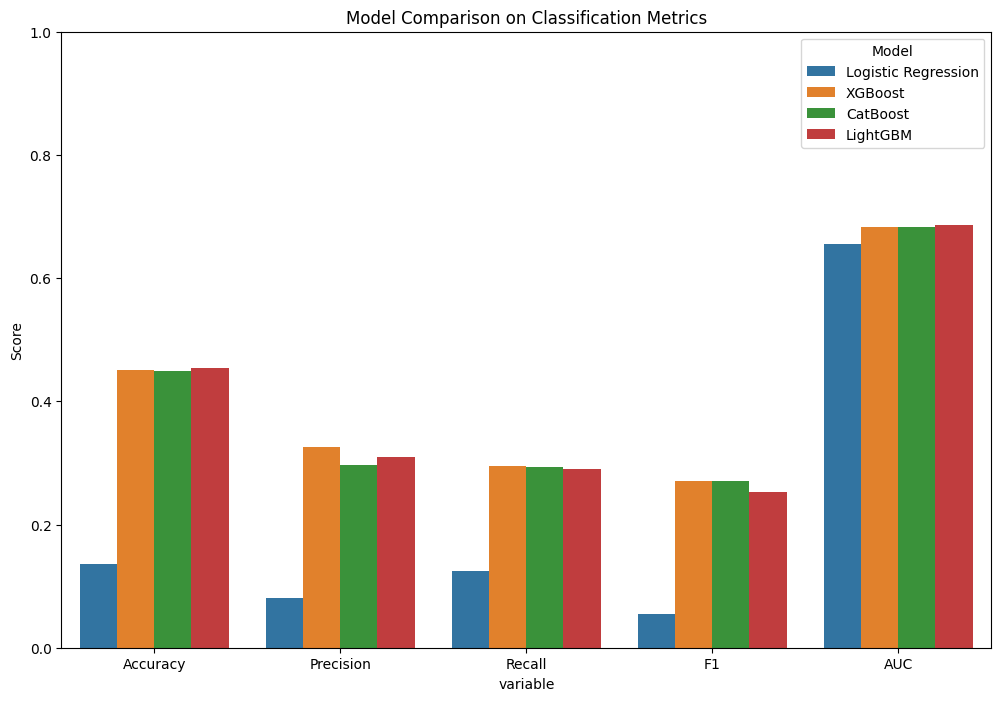

In [48]:
# Visualisation of the models
plt.figure(figsize=(12,8))
melted = metrics_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
sns.barplot(x='variable', y='value', hue='Model', data=melted)
plt.title('Model Comparison on Classification Metrics')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

In [49]:
# Select best model based on highest  AUC
best_model_row = metrics_df.sort_values(by='AUC', ascending=False).iloc[0]

print(f"\nFinal Decision: We choose {best_model_row['Model']} because it achieved the highest F1 score of {best_model_row['F1']:.2f}, with an accuracy of {best_model_row['Accuracy']:.2f} and AUC of {best_model_row['AUC']:.2f}.")


Final Decision: We choose LightGBM because it achieved the highest F1 score of 0.25, with an accuracy of 0.45 and AUC of 0.69.
